In [27]:
import numpy as np
import scipy as sp
import math
import torch
import matplotlib.pyplot as plt
import inspect
import textwrap
import random
from tqdm import tqdm
import optuna
import functools
from sklearn.model_selection import KFold

from typing import Callable
from torch import nn, optim
from data import diffeq, create_trainig_test_set, create_trainig_validation_test_set

import torch.nn.functional as F

from ray import tune
from ray.tune.schedulers import ASHAScheduler
from functools import partial
import pickle
from pathlib import Path

In [2]:
#Define the harmonic oscillator

def f(t,x,k):
    #write the function that is on the other side of the differential equation
    return -k*x

def differential_equation_1_order(t, x, k):
    dx_dt = f(t,x,k)
    return dx_dt

def differential_equation_2_order(t, X, k):
    #rewrite d^2x/dt^2 as dy/dt where y=dx/dt
    x, y = X
    dx_dt = y
    dy_dt = f(t,x,k)

    return [dx_dt, dy_dt]

In [3]:
torch.manual_seed(0) #get the same random numbers everytime you run the code

t_span = (0, 10)
n_step = 100
n_data = 1000
coeff_test = 0.3

harmonic_osc = diffeq(differential_equation_2_order, 2, 1)

train, test = create_trainig_test_set(harmonic_osc, t_span, n_step, n_data, coeff_test, "RK45")
print(train["X"][0].shape)
in_features = train["X"][0].shape[0]

torch.Size([103])


In [4]:
if torch.accelerator.is_available():
    device = torch.accelerator.current_accelerator().type
else:
    device = "cpu"
print(device)

cpu


In [5]:
class Harmonic(nn.Module):
    def __init__(self, n_step):
        super().__init__()
        self.fc1 = nn.Linear(in_features=in_features, out_features=32)
        self.fc2 = nn.Linear(32, n_step)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))     # smooth activation
        x = self.fc2(x)
        return x

# Initiate the model
model = Harmonic(n_step)

In [6]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4) #updates model parameters based on the gradients computed from the loss, lr = learning rate

In [7]:
epochs = 10000

for epoch in range(epochs):
    T_pred = model(train["X"])
    
    loss = loss_func(T_pred, train["y_tensor"][0:, 0])

    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()

    if (epoch+1) % (int(epochs/100)) == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

Epoch 100/10000, Loss: 0.7714
Epoch 200/10000, Loss: 0.7280
Epoch 300/10000, Loss: 0.6234
Epoch 400/10000, Loss: 0.5617
Epoch 500/10000, Loss: 0.5406
Epoch 600/10000, Loss: 0.5290
Epoch 700/10000, Loss: 0.5199
Epoch 800/10000, Loss: 0.5110
Epoch 900/10000, Loss: 0.5014
Epoch 1000/10000, Loss: 0.4907
Epoch 1100/10000, Loss: 0.4777
Epoch 1200/10000, Loss: 0.4691
Epoch 1300/10000, Loss: 0.4466
Epoch 1400/10000, Loss: 0.4307
Epoch 1500/10000, Loss: 0.4071
Epoch 1600/10000, Loss: 0.3851
Epoch 1700/10000, Loss: 0.3647
Epoch 1800/10000, Loss: 0.3468
Epoch 1900/10000, Loss: 0.3309
Epoch 2000/10000, Loss: 0.3168
Epoch 2100/10000, Loss: 0.2996
Epoch 2200/10000, Loss: 0.2865
Epoch 2300/10000, Loss: 0.2779
Epoch 2400/10000, Loss: 0.2636
Epoch 2500/10000, Loss: 0.2550
Epoch 2600/10000, Loss: 0.2493
Epoch 2700/10000, Loss: 0.2296
Epoch 2800/10000, Loss: 0.2176
Epoch 2900/10000, Loss: 0.2057
Epoch 3000/10000, Loss: 0.1930
Epoch 3100/10000, Loss: 0.1818
Epoch 3200/10000, Loss: 0.1718
Epoch 3300/10000,

In [8]:
model.eval()
with torch.no_grad():
    T_pred_test = model(test["X"])
    print(T_pred_test)
    test_loss = loss_func(T_pred_test, test["y_tensor"][0:, 0])
    print(f"Test Loss: {test_loss.item():.4f}")

tensor([[ 1.0096,  1.0580,  1.1033,  ..., -0.7891, -0.7530, -0.7216],
        [ 0.1681,  0.2438,  0.3177,  ...,  0.8310,  0.8109,  0.7858],
        [ 0.3826,  0.4356,  0.4883,  ...,  1.3749,  1.3279,  1.2807],
        ...,
        [ 0.7246,  0.7365,  0.7456,  ...,  0.4202,  0.4421,  0.4595],
        [ 0.8754,  0.8999,  0.9199,  ...,  0.9122,  0.8944,  0.8713],
        [ 0.2632,  0.2720,  0.2797,  ...,  0.3948,  0.4096,  0.4214]])
Test Loss: 0.0334


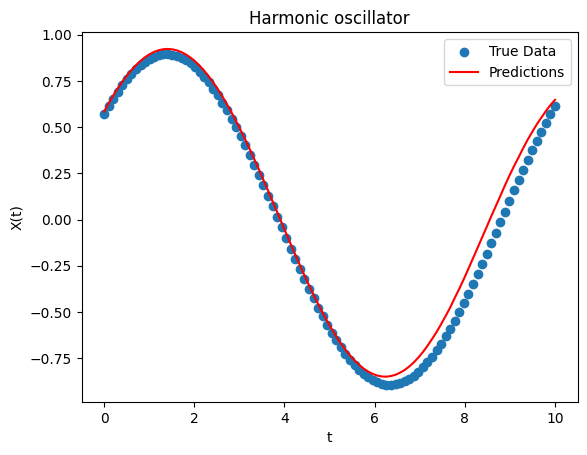

In [9]:
n = 30
plt.scatter(test["t_tensor"][n], test["y_tensor"][n][0], label="True Data")
plt.plot(test["t_tensor"][n], T_pred_test[n], color="red", label="Predictions")
plt.xlabel("t")
plt.ylabel("X(t)")
plt.title("Harmonic oscillator")
plt.legend()
plt.show()

# Hyperparameter optimization of the model

In [10]:
train2, validation2, test2 = create_trainig_validation_test_set(harmonic_osc, (0, 10), 100, 1000, [0.5, 0.2, 0.3], "RK45", device=device, seed=0)

In [11]:
class HarmonicModel(nn.Module):
    def __init__(self, n_in, n_layers, n_neurons, activation):
        super().__init__()
        layers = []
        act = {
            'tanh': nn.Tanh(),
            'sine': torch.sin,
            'gelu': nn.GELU(),
            'relu': nn.ReLU()
        }[activation]
        
        layers.append(nn.Linear(n_in, n_neurons))
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(n_neurons, n_neurons))
        layers.append(nn.Linear(n_neurons, 1))
        
        self.layers = nn.ModuleList(layers)
        self.activation = act

    def forward(self, x):
        for layer in self.layers[:-1]:
            if callable(self.activation):  # sine special case
                x = self.activation(layer(x))
            else:
                x = self.activation(layer(x))
        return self.layers[-1](x)

# test model
model = HarmonicModel(4, 2, 32, 'tanh').to(device)

In [12]:
def loss_harmonic(y_pred, y_exp, x_00, x_01, t, k, N_f):
    mse_y = torch.mean((y_pred - y_exp)**2)

    return mse_y

In [13]:
def train_harmonic(model, lr, epochs, data):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    X = data["X"]
    y_exp = data["y_tensor"][0:, 0:, 0].to(device)

    for epoch in range(epochs):
        y_pred = model(X).squeeze(-1)
        t = X[0:, 0:, 3]
        k = X[0:, 0:, 0]
        x_00 = X[0:, 0:, 1]
        x_01 = X[0:, 0:, 2]
    
        loss = loss_harmonic(y_pred, y_exp, x_00, x_01, t, k, N_f=1000)
    
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
    
        if (epoch+1) % (int(epochs)) == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

    return loss.item()

In [14]:
def rng_hparameters_search(n_trials, layers_i: tuple, neurons_i: tuple, activations_l: list, data, seed=0, device='cpu'):
    torch.manual_seed(seed)
    random.seed(seed)
    result = []

    for _ in tqdm(range(n_trials), desc="Hyperparameter search"):
        n_layers = random.randint(layers_i[0], layers_i[1])  # inclusive
        n_neurons = random.randint(neurons_i[0], neurons_i[1])
        activation = random.choice(activations_l)

        params = {
            'n_layers': n_layers,
            'n_neurons': n_neurons,
            'activation': activation
        }

        model = HarmonicModel(4, n_layers, n_neurons, activation).to(device)
        final_loss = train_harmonic(model, lr=0.01, epochs=100, data=data)
        result.append((params, final_loss))
    
    return result


In [15]:
n_trials = 100
results = rng_hparameters_search(n_trials, (1, 10), (1, 100), ['tanh', 'sine', 'gelu', 'relu'], validation2, seed=0)

Hyperparameter search:   1%|          | 1/100 [00:11<18:23, 11.15s/it]

Epoch 100/100, Loss: 0.8232


Hyperparameter search:   2%|▏         | 2/100 [00:11<07:58,  4.89s/it]

Epoch 100/100, Loss: 0.6376


Hyperparameter search:   3%|▎         | 3/100 [00:15<06:52,  4.25s/it]

Epoch 100/100, Loss: 0.1622


Hyperparameter search:   4%|▍         | 4/100 [00:24<10:02,  6.28s/it]

Epoch 100/100, Loss: 0.0287


Hyperparameter search:   5%|▌         | 5/100 [00:26<07:43,  4.88s/it]

Epoch 100/100, Loss: 0.0934


Hyperparameter search:   6%|▌         | 6/100 [00:32<08:02,  5.13s/it]

Epoch 100/100, Loss: 0.2036


Hyperparameter search:   7%|▋         | 7/100 [00:38<08:18,  5.36s/it]

Epoch 100/100, Loss: 0.1689


Hyperparameter search:   8%|▊         | 8/100 [00:39<06:09,  4.01s/it]

Epoch 100/100, Loss: 0.1269


Hyperparameter search:   9%|▉         | 9/100 [00:45<07:10,  4.73s/it]

Epoch 100/100, Loss: 0.0777


Hyperparameter search:  10%|█         | 10/100 [00:50<07:14,  4.82s/it]

Epoch 100/100, Loss: 0.2027


Hyperparameter search:  11%|█         | 11/100 [01:05<11:48,  7.96s/it]

Epoch 100/100, Loss: 0.1580


Hyperparameter search:  12%|█▏        | 12/100 [01:12<11:05,  7.57s/it]

Epoch 100/100, Loss: 0.1774


Hyperparameter search:  13%|█▎        | 13/100 [01:16<09:09,  6.31s/it]

Epoch 100/100, Loss: 0.2427


Hyperparameter search:  14%|█▍        | 14/100 [01:16<06:40,  4.66s/it]

Epoch 100/100, Loss: 0.5550


Hyperparameter search:  15%|█▌        | 15/100 [01:26<08:49,  6.23s/it]

Epoch 100/100, Loss: 0.4180


Hyperparameter search:  16%|█▌        | 16/100 [01:34<09:32,  6.82s/it]

Epoch 100/100, Loss: 0.6413


Hyperparameter search:  17%|█▋        | 17/100 [01:40<08:53,  6.43s/it]

Epoch 100/100, Loss: 0.0687


Hyperparameter search:  18%|█▊        | 18/100 [01:41<06:28,  4.74s/it]

Epoch 100/100, Loss: 0.0882


Hyperparameter search:  19%|█▉        | 19/100 [01:42<04:55,  3.64s/it]

Epoch 100/100, Loss: 0.1237


Hyperparameter search:  20%|██        | 20/100 [01:43<03:40,  2.75s/it]

Epoch 100/100, Loss: 0.2381


Hyperparameter search:  21%|██        | 21/100 [01:52<06:09,  4.67s/it]

Epoch 100/100, Loss: 0.8028


Hyperparameter search:  22%|██▏       | 22/100 [01:57<06:17,  4.83s/it]

Epoch 100/100, Loss: 0.1300


Hyperparameter search:  23%|██▎       | 23/100 [01:59<05:06,  3.98s/it]

Epoch 100/100, Loss: 0.1196


Hyperparameter search:  24%|██▍       | 24/100 [02:03<04:55,  3.89s/it]

Epoch 100/100, Loss: 0.3699


Hyperparameter search:  25%|██▌       | 25/100 [02:04<03:52,  3.10s/it]

Epoch 100/100, Loss: 0.5959


Hyperparameter search:  26%|██▌       | 26/100 [02:12<05:44,  4.65s/it]

Epoch 100/100, Loss: 0.0252


Hyperparameter search:  27%|██▋       | 27/100 [02:14<04:42,  3.87s/it]

Epoch 100/100, Loss: 0.0479


Hyperparameter search:  28%|██▊       | 28/100 [02:15<03:24,  2.83s/it]

Epoch 100/100, Loss: 0.3392


Hyperparameter search:  29%|██▉       | 29/100 [02:15<02:37,  2.21s/it]

Epoch 100/100, Loss: 0.4161


Hyperparameter search:  30%|███       | 30/100 [02:16<02:07,  1.82s/it]

Epoch 100/100, Loss: 0.2095


Hyperparameter search:  31%|███       | 31/100 [02:19<02:24,  2.09s/it]

Epoch 100/100, Loss: 0.1812


Hyperparameter search:  32%|███▏      | 32/100 [02:24<03:27,  3.04s/it]

Epoch 100/100, Loss: 0.0948


Hyperparameter search:  33%|███▎      | 33/100 [02:30<04:24,  3.95s/it]

Epoch 100/100, Loss: 0.1094


Hyperparameter search:  34%|███▍      | 34/100 [02:35<04:34,  4.16s/it]

Epoch 100/100, Loss: 0.2702


Hyperparameter search:  35%|███▌      | 35/100 [02:48<07:22,  6.80s/it]

Epoch 100/100, Loss: 0.0807


Hyperparameter search:  36%|███▌      | 36/100 [02:50<05:37,  5.28s/it]

Epoch 100/100, Loss: 0.4337


Hyperparameter search:  37%|███▋      | 37/100 [02:59<06:42,  6.39s/it]

Epoch 100/100, Loss: 0.6777


Hyperparameter search:  38%|███▊      | 38/100 [03:00<05:04,  4.91s/it]

Epoch 100/100, Loss: 0.1477


Hyperparameter search:  39%|███▉      | 39/100 [03:01<03:52,  3.80s/it]

Epoch 100/100, Loss: 0.0359


Hyperparameter search:  40%|████      | 40/100 [03:03<03:13,  3.22s/it]

Epoch 100/100, Loss: 0.0781


Hyperparameter search:  41%|████      | 41/100 [03:04<02:25,  2.47s/it]

Epoch 100/100, Loss: 0.3623


Hyperparameter search:  42%|████▏     | 42/100 [03:09<03:08,  3.25s/it]

Epoch 100/100, Loss: 0.0289


Hyperparameter search:  43%|████▎     | 43/100 [03:10<02:26,  2.57s/it]

Epoch 100/100, Loss: 0.5956


Hyperparameter search:  44%|████▍     | 44/100 [03:10<01:49,  1.95s/it]

Epoch 100/100, Loss: 0.5130


Hyperparameter search:  45%|████▌     | 45/100 [03:21<04:05,  4.47s/it]

Epoch 100/100, Loss: 0.5321


Hyperparameter search:  46%|████▌     | 46/100 [03:22<03:09,  3.51s/it]

Epoch 100/100, Loss: 0.1384


Hyperparameter search:  47%|████▋     | 47/100 [03:22<02:15,  2.56s/it]

Epoch 100/100, Loss: 0.5489


Hyperparameter search:  48%|████▊     | 48/100 [03:24<01:53,  2.19s/it]

Epoch 100/100, Loss: 0.1432


Hyperparameter search:  49%|████▉     | 49/100 [03:27<02:07,  2.50s/it]

Epoch 100/100, Loss: 0.2093


Hyperparameter search:  50%|█████     | 50/100 [03:29<01:56,  2.33s/it]

Epoch 100/100, Loss: 0.4868


Hyperparameter search:  51%|█████     | 51/100 [03:32<02:05,  2.56s/it]

Epoch 100/100, Loss: 0.1998


Hyperparameter search:  52%|█████▏    | 52/100 [03:34<01:52,  2.34s/it]

Epoch 100/100, Loss: 0.3847


Hyperparameter search:  53%|█████▎    | 53/100 [03:38<02:11,  2.79s/it]

Epoch 100/100, Loss: 0.0983


Hyperparameter search:  54%|█████▍    | 54/100 [03:38<01:34,  2.06s/it]

Epoch 100/100, Loss: 0.2081


Hyperparameter search:  55%|█████▌    | 55/100 [03:39<01:20,  1.80s/it]

Epoch 100/100, Loss: 0.6115


Hyperparameter search:  56%|█████▌    | 56/100 [03:42<01:26,  1.97s/it]

Epoch 100/100, Loss: 0.1737


Hyperparameter search:  57%|█████▋    | 57/100 [03:53<03:26,  4.79s/it]

Epoch 100/100, Loss: 0.2482


Hyperparameter search:  58%|█████▊    | 58/100 [03:57<03:12,  4.59s/it]

Epoch 100/100, Loss: 0.0891


Hyperparameter search:  59%|█████▉    | 59/100 [03:58<02:26,  3.58s/it]

Epoch 100/100, Loss: 0.5131


Hyperparameter search:  60%|██████    | 60/100 [04:00<02:00,  3.02s/it]

Epoch 100/100, Loss: 0.0596


Hyperparameter search:  61%|██████    | 61/100 [04:01<01:38,  2.52s/it]

Epoch 100/100, Loss: 0.1672


Hyperparameter search:  62%|██████▏   | 62/100 [04:02<01:13,  1.94s/it]

Epoch 100/100, Loss: 0.7304


Hyperparameter search:  63%|██████▎   | 63/100 [04:10<02:22,  3.85s/it]

Epoch 100/100, Loss: 0.1350


Hyperparameter search:  64%|██████▍   | 64/100 [04:15<02:24,  4.01s/it]

Epoch 100/100, Loss: 0.6720


Hyperparameter search:  65%|██████▌   | 65/100 [04:18<02:12,  3.78s/it]

Epoch 100/100, Loss: 0.0974


Hyperparameter search:  66%|██████▌   | 66/100 [04:32<03:50,  6.78s/it]

Epoch 100/100, Loss: 0.2059


Hyperparameter search:  67%|██████▋   | 67/100 [04:41<04:14,  7.71s/it]

Epoch 100/100, Loss: 0.3427


Hyperparameter search:  68%|██████▊   | 68/100 [04:47<03:44,  7.02s/it]

Epoch 100/100, Loss: 0.0419


Hyperparameter search:  69%|██████▉   | 69/100 [04:53<03:24,  6.60s/it]

Epoch 100/100, Loss: 0.0664


Hyperparameter search:  70%|███████   | 70/100 [05:01<03:31,  7.04s/it]

Epoch 100/100, Loss: 0.7697


Hyperparameter search:  71%|███████   | 71/100 [05:08<03:30,  7.26s/it]

Epoch 100/100, Loss: 0.0356


Hyperparameter search:  72%|███████▏  | 72/100 [05:12<02:49,  6.07s/it]

Epoch 100/100, Loss: 0.1156


Hyperparameter search:  73%|███████▎  | 73/100 [05:12<01:57,  4.35s/it]

Epoch 100/100, Loss: 1.0908


Hyperparameter search:  74%|███████▍  | 74/100 [05:14<01:35,  3.69s/it]

Epoch 100/100, Loss: 0.0750


Hyperparameter search:  75%|███████▌  | 75/100 [05:19<01:44,  4.19s/it]

Epoch 100/100, Loss: 0.0936


Hyperparameter search:  76%|███████▌  | 76/100 [05:29<02:19,  5.82s/it]

Epoch 100/100, Loss: 0.6967


Hyperparameter search:  77%|███████▋  | 77/100 [05:30<01:40,  4.38s/it]

Epoch 100/100, Loss: 0.4712


Hyperparameter search:  78%|███████▊  | 78/100 [05:31<01:12,  3.29s/it]

Epoch 100/100, Loss: 0.5790


Hyperparameter search:  79%|███████▉  | 79/100 [05:33<00:59,  2.83s/it]

Epoch 100/100, Loss: 0.1719


Hyperparameter search:  80%|████████  | 80/100 [05:41<01:28,  4.43s/it]

Epoch 100/100, Loss: 0.3441


Hyperparameter search:  81%|████████  | 81/100 [05:51<01:57,  6.17s/it]

Epoch 100/100, Loss: 0.3529


Hyperparameter search:  82%|████████▏ | 82/100 [05:52<01:21,  4.55s/it]

Epoch 100/100, Loss: 0.4992


Hyperparameter search:  83%|████████▎ | 83/100 [05:55<01:10,  4.17s/it]

Epoch 100/100, Loss: 0.0867


Hyperparameter search:  84%|████████▍ | 84/100 [05:57<00:58,  3.63s/it]

Epoch 100/100, Loss: 0.2844


Hyperparameter search:  85%|████████▌ | 85/100 [05:58<00:39,  2.65s/it]

Epoch 100/100, Loss: 0.8804


Hyperparameter search:  86%|████████▌ | 86/100 [06:01<00:40,  2.91s/it]

Epoch 100/100, Loss: 0.1342


Hyperparameter search:  87%|████████▋ | 87/100 [06:02<00:28,  2.19s/it]

Epoch 100/100, Loss: 0.8816


Hyperparameter search:  88%|████████▊ | 88/100 [06:13<00:59,  4.95s/it]

Epoch 100/100, Loss: 0.4339


Hyperparameter search:  89%|████████▉ | 89/100 [06:14<00:41,  3.74s/it]

Epoch 100/100, Loss: 0.0565


Hyperparameter search:  90%|█████████ | 90/100 [06:17<00:34,  3.45s/it]

Epoch 100/100, Loss: 0.0207


Hyperparameter search:  91%|█████████ | 91/100 [06:19<00:26,  2.97s/it]

Epoch 100/100, Loss: 0.2231


Hyperparameter search:  92%|█████████▏| 92/100 [06:19<00:17,  2.23s/it]

Epoch 100/100, Loss: 0.5174


Hyperparameter search:  93%|█████████▎| 93/100 [06:21<00:15,  2.23s/it]

Epoch 100/100, Loss: 0.1555


Hyperparameter search:  94%|█████████▍| 94/100 [06:26<00:17,  2.86s/it]

Epoch 100/100, Loss: 0.0240


Hyperparameter search:  95%|█████████▌| 95/100 [06:27<00:11,  2.26s/it]

Epoch 100/100, Loss: 0.2196


Hyperparameter search:  96%|█████████▌| 96/100 [06:27<00:06,  1.67s/it]

Epoch 100/100, Loss: 0.6861


Hyperparameter search:  97%|█████████▋| 97/100 [06:33<00:08,  2.90s/it]

Epoch 100/100, Loss: 0.0251


Hyperparameter search:  98%|█████████▊| 98/100 [06:38<00:06,  3.48s/it]

Epoch 100/100, Loss: 0.0996


Hyperparameter search:  99%|█████████▉| 99/100 [06:38<00:02,  2.70s/it]

Epoch 100/100, Loss: 0.4691


Hyperparameter search: 100%|██████████| 100/100 [06:48<00:00,  4.09s/it]

Epoch 100/100, Loss: 0.5674


In [16]:
# Define your hyperparameter ranges and data
layers_i = (1, 10)
neurons_i = (4, 128)
activations_l = ['tanh', 'sine', 'gelu', 'relu']
data = validation2  # your dataset
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def objective(trial, layers_i, neurons_i, activations_l, data):
    n_layers = trial.suggest_int("n_layers", layers_i[0], layers_i[1])
    n_neurons = trial.suggest_int("n_neurons", neurons_i[0], neurons_i[1])
    activation = trial.suggest_categorical("activation", activations_l)

    model = HarmonicModel(4, n_layers, n_neurons, activation).to(device)
    final_loss = train_harmonic(model, lr=0.01, epochs=100, data=data)
    return final_loss

# Use functools.partial to pass extra arguments
objective_fixed = functools.partial(objective, layers_i=layers_i, neurons_i=neurons_i,
                                    activations_l=activations_l, data=data)

study = optuna.create_study(direction="minimize")
study.optimize(objective_fixed, n_trials=50)


[I 2025-11-19 16:04:29,405] A new study created in memory with name: no-name-dfafda37-2fad-4544-ac33-141a97cb5338
[I 2025-11-19 16:04:33,798] Trial 0 finished with value: 0.11605167388916016 and parameters: {'n_layers': 8, 'n_neurons': 42, 'activation': 'tanh'}. Best is trial 0 with value: 0.11605167388916016.


Epoch 100/100, Loss: 0.1161


[I 2025-11-19 16:04:34,376] Trial 1 finished with value: 0.6348323225975037 and parameters: {'n_layers': 1, 'n_neurons': 23, 'activation': 'gelu'}. Best is trial 0 with value: 0.11605167388916016.


Epoch 100/100, Loss: 0.6348


[I 2025-11-19 16:04:35,671] Trial 2 finished with value: 0.17315781116485596 and parameters: {'n_layers': 3, 'n_neurons': 24, 'activation': 'sine'}. Best is trial 0 with value: 0.11605167388916016.


Epoch 100/100, Loss: 0.1732


[I 2025-11-19 16:04:41,322] Trial 3 finished with value: 0.05256938934326172 and parameters: {'n_layers': 5, 'n_neurons': 68, 'activation': 'gelu'}. Best is trial 3 with value: 0.05256938934326172.


Epoch 100/100, Loss: 0.0526


[I 2025-11-19 16:04:42,801] Trial 4 finished with value: 0.12770332396030426 and parameters: {'n_layers': 2, 'n_neurons': 47, 'activation': 'relu'}. Best is trial 3 with value: 0.05256938934326172.


Epoch 100/100, Loss: 0.1277


[I 2025-11-19 16:04:54,371] Trial 5 finished with value: 0.4022708535194397 and parameters: {'n_layers': 5, 'n_neurons': 118, 'activation': 'relu'}. Best is trial 3 with value: 0.05256938934326172.


Epoch 100/100, Loss: 0.4023


[I 2025-11-19 16:05:06,012] Trial 6 finished with value: 0.0924447625875473 and parameters: {'n_layers': 5, 'n_neurons': 124, 'activation': 'gelu'}. Best is trial 3 with value: 0.05256938934326172.


Epoch 100/100, Loss: 0.0924


[I 2025-11-19 16:05:06,911] Trial 7 finished with value: 0.5581808090209961 and parameters: {'n_layers': 1, 'n_neurons': 74, 'activation': 'gelu'}. Best is trial 3 with value: 0.05256938934326172.


Epoch 100/100, Loss: 0.5582


[I 2025-11-19 16:05:07,239] Trial 8 finished with value: 0.5670114755630493 and parameters: {'n_layers': 1, 'n_neurons': 14, 'activation': 'gelu'}. Best is trial 3 with value: 0.05256938934326172.


Epoch 100/100, Loss: 0.5670


[I 2025-11-19 16:05:07,672] Trial 9 finished with value: 0.43645787239074707 and parameters: {'n_layers': 1, 'n_neurons': 22, 'activation': 'relu'}. Best is trial 3 with value: 0.05256938934326172.


Epoch 100/100, Loss: 0.4365


[I 2025-11-19 16:05:28,540] Trial 10 finished with value: 0.1710677295923233 and parameters: {'n_layers': 10, 'n_neurons': 87, 'activation': 'sine'}. Best is trial 3 with value: 0.05256938934326172.


Epoch 100/100, Loss: 0.1711


[I 2025-11-19 16:05:40,388] Trial 11 finished with value: 0.03175980597734451 and parameters: {'n_layers': 5, 'n_neurons': 118, 'activation': 'gelu'}. Best is trial 11 with value: 0.03175980597734451.


Epoch 100/100, Loss: 0.0318


[I 2025-11-19 16:05:51,998] Trial 12 finished with value: 0.07978791743516922 and parameters: {'n_layers': 7, 'n_neurons': 101, 'activation': 'gelu'}. Best is trial 11 with value: 0.03175980597734451.


Epoch 100/100, Loss: 0.0798


[I 2025-11-19 16:05:58,040] Trial 13 finished with value: 0.120010145008564 and parameters: {'n_layers': 4, 'n_neurons': 98, 'activation': 'tanh'}. Best is trial 11 with value: 0.03175980597734451.


Epoch 100/100, Loss: 0.1200


[I 2025-11-19 16:06:03,766] Trial 14 finished with value: 0.7643803358078003 and parameters: {'n_layers': 7, 'n_neurons': 55, 'activation': 'gelu'}. Best is trial 11 with value: 0.03175980597734451.


Epoch 100/100, Loss: 0.7644


[I 2025-11-19 16:06:10,051] Trial 15 finished with value: 0.2122478485107422 and parameters: {'n_layers': 6, 'n_neurons': 72, 'activation': 'gelu'}. Best is trial 11 with value: 0.03175980597734451.


Epoch 100/100, Loss: 0.2122


[I 2025-11-19 16:06:16,682] Trial 16 finished with value: 0.017241815105080605 and parameters: {'n_layers': 4, 'n_neurons': 109, 'activation': 'gelu'}. Best is trial 16 with value: 0.017241815105080605.


Epoch 100/100, Loss: 0.0172


[I 2025-11-19 16:06:21,664] Trial 17 finished with value: 0.19741787016391754 and parameters: {'n_layers': 3, 'n_neurons': 108, 'activation': 'tanh'}. Best is trial 16 with value: 0.017241815105080605.


Epoch 100/100, Loss: 0.1974


[I 2025-11-19 16:06:28,564] Trial 18 finished with value: 0.05079418793320656 and parameters: {'n_layers': 3, 'n_neurons': 128, 'activation': 'sine'}. Best is trial 16 with value: 0.017241815105080605.


Epoch 100/100, Loss: 0.0508


[I 2025-11-19 16:06:45,158] Trial 19 finished with value: 0.0927882045507431 and parameters: {'n_layers': 9, 'n_neurons': 91, 'activation': 'gelu'}. Best is trial 16 with value: 0.017241815105080605.


Epoch 100/100, Loss: 0.0928


[I 2025-11-19 16:06:53,139] Trial 20 finished with value: 0.02542605809867382 and parameters: {'n_layers': 4, 'n_neurons': 112, 'activation': 'gelu'}. Best is trial 16 with value: 0.017241815105080605.


Epoch 100/100, Loss: 0.0254


[I 2025-11-19 16:07:01,032] Trial 21 finished with value: 0.050785597413778305 and parameters: {'n_layers': 4, 'n_neurons': 113, 'activation': 'gelu'}. Best is trial 16 with value: 0.017241815105080605.


Epoch 100/100, Loss: 0.0508


[I 2025-11-19 16:07:07,722] Trial 22 finished with value: 0.012440431863069534 and parameters: {'n_layers': 4, 'n_neurons': 108, 'activation': 'gelu'}. Best is trial 22 with value: 0.012440431863069534.


Epoch 100/100, Loss: 0.0124


[I 2025-11-19 16:07:13,019] Trial 23 finished with value: 0.03003770112991333 and parameters: {'n_layers': 4, 'n_neurons': 83, 'activation': 'gelu'}. Best is trial 22 with value: 0.012440431863069534.


Epoch 100/100, Loss: 0.0300


[I 2025-11-19 16:07:23,222] Trial 24 finished with value: 0.08249938488006592 and parameters: {'n_layers': 6, 'n_neurons': 103, 'activation': 'gelu'}. Best is trial 22 with value: 0.012440431863069534.


Epoch 100/100, Loss: 0.0825


[I 2025-11-19 16:07:27,594] Trial 25 finished with value: 0.02917260117828846 and parameters: {'n_layers': 3, 'n_neurons': 93, 'activation': 'gelu'}. Best is trial 22 with value: 0.012440431863069534.


Epoch 100/100, Loss: 0.0292


[I 2025-11-19 16:07:31,124] Trial 26 finished with value: 0.11044570058584213 and parameters: {'n_layers': 2, 'n_neurons': 109, 'activation': 'sine'}. Best is trial 22 with value: 0.012440431863069534.


Epoch 100/100, Loss: 0.1104


[I 2025-11-19 16:07:36,264] Trial 27 finished with value: 0.0862153172492981 and parameters: {'n_layers': 4, 'n_neurons': 83, 'activation': 'tanh'}. Best is trial 22 with value: 0.012440431863069534.


Epoch 100/100, Loss: 0.0862


[I 2025-11-19 16:07:39,619] Trial 28 finished with value: 0.32036682963371277 and parameters: {'n_layers': 2, 'n_neurons': 119, 'activation': 'relu'}. Best is trial 22 with value: 0.012440431863069534.


Epoch 100/100, Loss: 0.3204


[I 2025-11-19 16:07:44,690] Trial 29 finished with value: 0.09473741799592972 and parameters: {'n_layers': 6, 'n_neurons': 59, 'activation': 'tanh'}. Best is trial 22 with value: 0.012440431863069534.


Epoch 100/100, Loss: 0.0947


[I 2025-11-19 16:07:52,807] Trial 30 finished with value: 0.018707275390625 and parameters: {'n_layers': 7, 'n_neurons': 78, 'activation': 'gelu'}. Best is trial 22 with value: 0.012440431863069534.


Epoch 100/100, Loss: 0.0187


[I 2025-11-19 16:08:07,036] Trial 31 finished with value: 0.13232269883155823 and parameters: {'n_layers': 8, 'n_neurons': 104, 'activation': 'gelu'}. Best is trial 22 with value: 0.012440431863069534.


Epoch 100/100, Loss: 0.1323


[I 2025-11-19 16:08:15,079] Trial 32 finished with value: 0.8813525438308716 and parameters: {'n_layers': 7, 'n_neurons': 77, 'activation': 'gelu'}. Best is trial 22 with value: 0.012440431863069534.


Epoch 100/100, Loss: 0.8814


[I 2025-11-19 16:08:26,576] Trial 33 finished with value: 0.19160154461860657 and parameters: {'n_layers': 8, 'n_neurons': 96, 'activation': 'gelu'}. Best is trial 22 with value: 0.012440431863069534.


Epoch 100/100, Loss: 0.1916


[I 2025-11-19 16:08:33,313] Trial 34 finished with value: 0.02679932489991188 and parameters: {'n_layers': 4, 'n_neurons': 112, 'activation': 'gelu'}. Best is trial 22 with value: 0.012440431863069534.


Epoch 100/100, Loss: 0.0268


[I 2025-11-19 16:08:35,935] Trial 35 finished with value: 0.05006926879286766 and parameters: {'n_layers': 5, 'n_neurons': 41, 'activation': 'gelu'}. Best is trial 22 with value: 0.012440431863069534.


Epoch 100/100, Loss: 0.0501


[I 2025-11-19 16:08:41,767] Trial 36 finished with value: 0.705683708190918 and parameters: {'n_layers': 6, 'n_neurons': 63, 'activation': 'gelu'}. Best is trial 22 with value: 0.012440431863069534.


Epoch 100/100, Loss: 0.7057


[I 2025-11-19 16:08:47,670] Trial 37 finished with value: 0.14172658324241638 and parameters: {'n_layers': 3, 'n_neurons': 128, 'activation': 'relu'}. Best is trial 22 with value: 0.012440431863069534.


Epoch 100/100, Loss: 0.1417


[I 2025-11-19 16:08:49,681] Trial 38 finished with value: 0.019392870366573334 and parameters: {'n_layers': 4, 'n_neurons': 43, 'activation': 'sine'}. Best is trial 22 with value: 0.012440431863069534.


Epoch 100/100, Loss: 0.0194


[I 2025-11-19 16:08:52,201] Trial 39 finished with value: 0.028830669820308685 and parameters: {'n_layers': 5, 'n_neurons': 35, 'activation': 'sine'}. Best is trial 22 with value: 0.012440431863069534.


Epoch 100/100, Loss: 0.0288


[I 2025-11-19 16:08:52,532] Trial 40 finished with value: 0.5872467160224915 and parameters: {'n_layers': 2, 'n_neurons': 4, 'activation': 'sine'}. Best is trial 22 with value: 0.012440431863069534.


Epoch 100/100, Loss: 0.5872


[I 2025-11-19 16:08:55,116] Trial 41 finished with value: 0.034879911690950394 and parameters: {'n_layers': 4, 'n_neurons': 34, 'activation': 'sine'}. Best is trial 22 with value: 0.012440431863069534.


Epoch 100/100, Loss: 0.0349


[I 2025-11-19 16:08:57,221] Trial 42 finished with value: 0.03476586192846298 and parameters: {'n_layers': 3, 'n_neurons': 44, 'activation': 'sine'}. Best is trial 22 with value: 0.012440431863069534.


Epoch 100/100, Loss: 0.0348


[I 2025-11-19 16:09:00,608] Trial 43 finished with value: 0.03545064851641655 and parameters: {'n_layers': 5, 'n_neurons': 52, 'activation': 'gelu'}. Best is trial 22 with value: 0.012440431863069534.


Epoch 100/100, Loss: 0.0355


[I 2025-11-19 16:09:09,360] Trial 44 finished with value: 0.10162726789712906 and parameters: {'n_layers': 4, 'n_neurons': 116, 'activation': 'sine'}. Best is trial 22 with value: 0.012440431863069534.


Epoch 100/100, Loss: 0.1016


[I 2025-11-19 16:09:12,891] Trial 45 finished with value: 0.08793064951896667 and parameters: {'n_layers': 3, 'n_neurons': 79, 'activation': 'relu'}. Best is trial 22 with value: 0.012440431863069534.


Epoch 100/100, Loss: 0.0879


[I 2025-11-19 16:09:19,972] Trial 46 finished with value: 0.12518131732940674 and parameters: {'n_layers': 7, 'n_neurons': 66, 'activation': 'gelu'}. Best is trial 22 with value: 0.012440431863069534.


Epoch 100/100, Loss: 0.1252


[I 2025-11-19 16:09:31,259] Trial 47 finished with value: 0.1862129271030426 and parameters: {'n_layers': 5, 'n_neurons': 122, 'activation': 'gelu'}. Best is trial 22 with value: 0.012440431863069534.


Epoch 100/100, Loss: 0.1862


[I 2025-11-19 16:09:36,330] Trial 48 finished with value: 0.12542350590229034 and parameters: {'n_layers': 4, 'n_neurons': 89, 'activation': 'gelu'}. Best is trial 22 with value: 0.012440431863069534.


Epoch 100/100, Loss: 0.1254


[I 2025-11-19 16:09:38,384] Trial 49 finished with value: 0.24587516486644745 and parameters: {'n_layers': 9, 'n_neurons': 27, 'activation': 'tanh'}. Best is trial 22 with value: 0.012440431863069534.


Epoch 100/100, Loss: 0.2459


In [23]:
print("Best params:", study.best_params)
print("Best loss:", study.best_value)

Best params: {'n_layers': 4, 'n_neurons': 108, 'activation': 'gelu'}
Best loss: 0.012440431863069534


In [24]:
best_params, best_loss = min(results, key=lambda x: x[1])
print("\nBest configuration:")
print(best_params)
print(f"Final loss: {best_loss:.3e}")


Best configuration:
{'n_layers': 5, 'n_neurons': 36, 'activation': 'sine'}
Final loss: 2.074e-02


# Test best hyperparameters

In [19]:
n_layers_opt_rand = best_params["n_layers"]
n_neurons_opt_rand = best_params["n_neurons"]
activation_opt_rand = best_params["activation"]

n_layers_opt_bayes = study.best_params["n_layers"]
n_neurons_opt_bayes = study.best_params["n_neurons"]
activation_opt_bayes = study.best_params["activation"]

model_optimized_rand = HarmonicModel(4, n_layers_opt_rand, n_neurons_opt_rand, activation_opt_rand).to(device)
model_optimized_bayes = HarmonicModel(4, n_layers_opt_bayes, n_neurons_opt_bayes, activation_opt_bayes).to(device)

In [20]:
# training
loss_last_rand= train_harmonic(model_optimized_rand, 0.01, 1000, train2)
loss_last_bayes = train_harmonic(model_optimized_bayes, 0.01, 1000, train2)

Epoch 1000/1000, Loss: 0.0015
Epoch 1000/1000, Loss: 0.0017


In [21]:
# test dataset random
model_optimized_rand.eval()
X = test2["X"]
y_exp = test2["y_tensor"][0:, 0:, 0].to(device)
y_pred_rand = model_optimized_rand(X).squeeze(-1)
t = X[0:, 0:, 3]
k = X[0:, 0:, 0]
x_00 = X[0:, 0:, 1]
x_01 = X[0:, 0:, 2]
test_loss_rand = loss_harmonic(y_pred_rand, y_exp, x_00, x_01, t, k, N_f=100)
print(f"Test Loss Random optimization: {test_loss_rand.item():.4f}")

# test dataset bayes
model_optimized_bayes.eval()
X = test2["X"]
y_exp = test2["y_tensor"][0:, 0:, 0].to(device)
y_pred_bayes = model_optimized_bayes(X).squeeze(-1)
t = X[0:, 0:, 3]
k = X[0:, 0:, 0]
x_00 = X[0:, 0:, 1]
x_01 = X[0:, 0:, 2]
test_loss_bayes = loss_harmonic(y_pred_bayes, y_exp, x_00, x_01, t, k, N_f=100)
print(f"Test Loss Random optimization: {test_loss_bayes.item():.4f}")

Test Loss Random optimization: 0.0068
Test Loss Random optimization: 0.0022


torch.Size([300, 100])
torch.Size([300, 100])


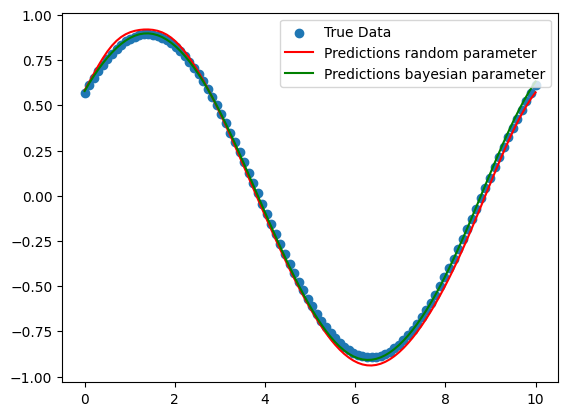

In [22]:
print(y_pred_rand.shape)
print(y_pred_bayes.shape)

y_pred_rand.to("cpu")
y_pred_bayes.to("cpu")
test2["t_tensor"].to("cpu")

n = 30
plt.scatter(test2["t_tensor"][n], test2["y_tensor"][n][0:, 0], label="True Data")
plt.plot(test2["t_tensor"][n], y_pred_rand.cpu().detach()[n], color="red", label="Predictions random parameter")
plt.plot(test2["t_tensor"][n], y_pred_bayes.cpu().detach()[n], color="green", label="Predictions bayesian parameter")
plt.legend()
plt.show()

In [31]:
K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=42)
fold_losses = []

for train_idx, val_idx in kf.split(data['args_tensor']):
    # Slice each tensor in the dictionary
    train_fold = {k: v[train_idx].to(device) for k, v in data.items()}
    val_fold   = {k: v[val_idx].to(device)   for k, v in data.items()}

    # Initialize model with best hyperparameters
    model = HarmonicModel(
        4,
        best_params['n_layers'],
        best_params['n_neurons'],
        best_params['activation']
    ).to(device)

    # Train model on this fold
    loss = train_harmonic(model, lr=0.01, epochs=100, data=(train_fold, val_fold))
    fold_losses.append(loss)

average_cv_loss = sum(fold_losses) / K
print("Estimated generalization loss (K-Fold CV):", average_cv_loss)


TypeError: tuple indices must be integers or slices, not str